In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states, 
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA], #, model.d_optQ
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates, 
                                                                   model.training: True})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.9070 dlossA:1.5317 dlossQ:5.8178 exploreP:0.9983
Episode:1 meanR:23.0000 R:29.0000 rate:0.0580 gloss:0.5265 dlossA:1.4851 dlossQ:4.0265 exploreP:0.9955
Episode:2 meanR:20.0000 R:14.0000 rate:0.0280 gloss:0.2487 dlossA:1.4365 dlossQ:2.7822 exploreP:0.9941
Episode:3 meanR:20.7500 R:23.0000 rate:0.0460 gloss:0.0951 dlossA:1.4090 dlossQ:2.3178 exploreP:0.9918
Episode:4 meanR:19.6000 R:15.0000 rate:0.0300 gloss:-0.1253 dlossA:1.3755 dlossQ:1.7536 exploreP:0.9903
Episode:5 meanR:25.8333 R:57.0000 rate:0.1140 gloss:-0.2342 dlossA:1.3335 dlossQ:1.7711 exploreP:0.9848
Episode:6 meanR:23.7143 R:11.0000 rate:0.0220 gloss:-0.1652 dlossA:1.3315 dlossQ:2.0871 exploreP:0.9837
Episode:7 meanR:24.2500 R:28.0000 rate:0.0560 gloss:-0.3683 dlossA:1.2719 dlossQ:1.6930 exploreP:0.9810
Episode:8 meanR:23.1111 R:14.0000 rate:0.0280 gloss:-0.2850 dlossA:1.2544 dlossQ:2.2967 exploreP:0.9796
Episode:9 meanR:23.5000 R:27.0000 rate:0.0540 gloss:-0.4120 dlossA:1

Episode:79 meanR:22.1000 R:28.0000 rate:0.0560 gloss:0.0221 dlossA:1.2151 dlossQ:4.8853 exploreP:0.8396
Episode:80 meanR:22.0123 R:15.0000 rate:0.0300 gloss:-0.2737 dlossA:1.1612 dlossQ:2.5954 exploreP:0.8383
Episode:81 meanR:22.5122 R:63.0000 rate:0.1260 gloss:0.1192 dlossA:1.2370 dlossQ:5.6593 exploreP:0.8331
Episode:82 meanR:22.6024 R:30.0000 rate:0.0600 gloss:-0.0777 dlossA:1.2085 dlossQ:4.6232 exploreP:0.8307
Episode:83 meanR:22.5119 R:15.0000 rate:0.0300 gloss:-0.0229 dlossA:1.2178 dlossQ:3.9063 exploreP:0.8294
Episode:84 meanR:22.4235 R:15.0000 rate:0.0300 gloss:0.1615 dlossA:1.2570 dlossQ:4.8340 exploreP:0.8282
Episode:85 meanR:22.3140 R:13.0000 rate:0.0260 gloss:-0.0117 dlossA:1.2235 dlossQ:4.9436 exploreP:0.8271
Episode:86 meanR:22.3333 R:24.0000 rate:0.0480 gloss:0.4531 dlossA:1.2964 dlossQ:7.6561 exploreP:0.8252
Episode:87 meanR:22.5795 R:44.0000 rate:0.0880 gloss:-0.1070 dlossA:1.2050 dlossQ:4.0504 exploreP:0.8216
Episode:88 meanR:22.5056 R:16.0000 rate:0.0320 gloss:0.1730

Episode:158 meanR:18.0800 R:14.0000 rate:0.0280 gloss:0.1667 dlossA:1.2347 dlossQ:6.2740 exploreP:0.7310
Episode:159 meanR:18.0600 R:11.0000 rate:0.0220 gloss:0.6420 dlossA:1.3210 dlossQ:8.6433 exploreP:0.7303
Episode:160 meanR:18.0200 R:10.0000 rate:0.0200 gloss:0.1150 dlossA:1.2340 dlossQ:5.7874 exploreP:0.7295
Episode:161 meanR:18.0000 R:14.0000 rate:0.0280 gloss:0.0171 dlossA:1.2058 dlossQ:5.5104 exploreP:0.7285
Episode:162 meanR:18.0000 R:13.0000 rate:0.0260 gloss:0.2867 dlossA:1.2470 dlossQ:6.3165 exploreP:0.7276
Episode:163 meanR:17.8500 R:13.0000 rate:0.0260 gloss:0.0406 dlossA:1.2055 dlossQ:5.0406 exploreP:0.7267
Episode:164 meanR:17.7800 R:20.0000 rate:0.0400 gloss:-0.0264 dlossA:1.2029 dlossQ:4.5059 exploreP:0.7252
Episode:165 meanR:17.7400 R:20.0000 rate:0.0400 gloss:0.0869 dlossA:1.2068 dlossQ:5.0403 exploreP:0.7238
Episode:166 meanR:17.7700 R:19.0000 rate:0.0380 gloss:0.1448 dlossA:1.2159 dlossQ:5.7394 exploreP:0.7224
Episode:167 meanR:17.7800 R:14.0000 rate:0.0280 gloss:

Episode:236 meanR:16.0900 R:23.0000 rate:0.0460 gloss:0.3123 dlossA:1.2490 dlossQ:7.9725 exploreP:0.6473
Episode:237 meanR:16.1000 R:11.0000 rate:0.0220 gloss:0.2763 dlossA:1.2317 dlossQ:5.8381 exploreP:0.6466
Episode:238 meanR:16.1100 R:20.0000 rate:0.0400 gloss:0.2577 dlossA:1.2423 dlossQ:5.9120 exploreP:0.6453
Episode:239 meanR:16.1000 R:13.0000 rate:0.0260 gloss:-0.1327 dlossA:1.1636 dlossQ:3.0996 exploreP:0.6445
Episode:240 meanR:15.9800 R:10.0000 rate:0.0200 gloss:0.1935 dlossA:1.2100 dlossQ:5.5426 exploreP:0.6438
Episode:241 meanR:15.9400 R:13.0000 rate:0.0260 gloss:-0.0058 dlossA:1.1726 dlossQ:4.0219 exploreP:0.6430
Episode:242 meanR:15.9100 R:13.0000 rate:0.0260 gloss:0.0333 dlossA:1.1980 dlossQ:3.8036 exploreP:0.6422
Episode:243 meanR:15.8900 R:9.0000 rate:0.0180 gloss:0.2446 dlossA:1.2291 dlossQ:5.2487 exploreP:0.6416
Episode:244 meanR:15.8900 R:11.0000 rate:0.0220 gloss:0.0758 dlossA:1.2046 dlossQ:3.9737 exploreP:0.6409
Episode:245 meanR:15.7900 R:19.0000 rate:0.0380 gloss:

Episode:315 meanR:15.1600 R:11.0000 rate:0.0220 gloss:0.0020 dlossA:1.1797 dlossQ:3.2060 exploreP:0.5759
Episode:316 meanR:15.1000 R:14.0000 rate:0.0280 gloss:0.2491 dlossA:1.2329 dlossQ:5.5646 exploreP:0.5751
Episode:317 meanR:15.0700 R:13.0000 rate:0.0260 gloss:0.1795 dlossA:1.2446 dlossQ:5.0292 exploreP:0.5744
Episode:318 meanR:15.0600 R:11.0000 rate:0.0220 gloss:-0.0253 dlossA:1.1790 dlossQ:3.6202 exploreP:0.5737
Episode:319 meanR:15.1400 R:19.0000 rate:0.0380 gloss:0.2172 dlossA:1.2484 dlossQ:6.0484 exploreP:0.5727
Episode:320 meanR:15.1000 R:10.0000 rate:0.0200 gloss:0.3774 dlossA:1.2911 dlossQ:10.7569 exploreP:0.5721
Episode:321 meanR:15.1400 R:14.0000 rate:0.0280 gloss:0.0727 dlossA:1.2217 dlossQ:3.9712 exploreP:0.5713
Episode:322 meanR:15.0900 R:12.0000 rate:0.0240 gloss:0.1824 dlossA:1.2364 dlossQ:6.1245 exploreP:0.5707
Episode:323 meanR:15.1500 R:18.0000 rate:0.0360 gloss:0.1626 dlossA:1.2289 dlossQ:6.4868 exploreP:0.5696
Episode:324 meanR:15.0000 R:12.0000 rate:0.0240 gloss

Episode:394 meanR:14.5900 R:11.0000 rate:0.0220 gloss:0.3588 dlossA:1.2792 dlossQ:7.0172 exploreP:0.5170
Episode:395 meanR:14.5800 R:21.0000 rate:0.0420 gloss:0.2560 dlossA:1.2507 dlossQ:4.7867 exploreP:0.5160
Episode:396 meanR:14.3500 R:11.0000 rate:0.0220 gloss:0.1008 dlossA:1.2358 dlossQ:3.4700 exploreP:0.5154
Episode:397 meanR:14.3600 R:13.0000 rate:0.0260 gloss:0.1963 dlossA:1.2240 dlossQ:4.8414 exploreP:0.5148
Episode:398 meanR:14.3000 R:12.0000 rate:0.0240 gloss:0.3124 dlossA:1.2669 dlossQ:5.0736 exploreP:0.5142
Episode:399 meanR:14.2700 R:10.0000 rate:0.0200 gloss:0.1592 dlossA:1.2165 dlossQ:4.0797 exploreP:0.5137
Episode:400 meanR:14.3300 R:19.0000 rate:0.0380 gloss:0.0637 dlossA:1.2083 dlossQ:3.4804 exploreP:0.5127
Episode:401 meanR:14.3700 R:21.0000 rate:0.0420 gloss:0.3363 dlossA:1.2590 dlossQ:6.3628 exploreP:0.5117
Episode:402 meanR:14.3700 R:12.0000 rate:0.0240 gloss:0.0210 dlossA:1.1950 dlossQ:3.2201 exploreP:0.5110
Episode:403 meanR:14.3700 R:14.0000 rate:0.0280 gloss:0

Episode:473 meanR:13.6200 R:11.0000 rate:0.0220 gloss:0.2466 dlossA:1.2509 dlossQ:4.9643 exploreP:0.4649
Episode:474 meanR:13.6200 R:10.0000 rate:0.0200 gloss:0.0147 dlossA:1.2068 dlossQ:3.0731 exploreP:0.4645
Episode:475 meanR:13.6400 R:14.0000 rate:0.0280 gloss:0.4737 dlossA:1.3042 dlossQ:7.7482 exploreP:0.4638
Episode:476 meanR:13.6400 R:9.0000 rate:0.0180 gloss:-0.0112 dlossA:1.1928 dlossQ:2.5776 exploreP:0.4634
Episode:477 meanR:13.6500 R:11.0000 rate:0.0220 gloss:0.3635 dlossA:1.3005 dlossQ:5.9014 exploreP:0.4629
Episode:478 meanR:13.6000 R:8.0000 rate:0.0160 gloss:-0.0246 dlossA:1.1931 dlossQ:2.6080 exploreP:0.4626
Episode:479 meanR:13.5900 R:13.0000 rate:0.0260 gloss:0.2416 dlossA:1.2679 dlossQ:6.0784 exploreP:0.4620
Episode:480 meanR:13.6400 R:13.0000 rate:0.0260 gloss:-0.0505 dlossA:1.1781 dlossQ:2.6573 exploreP:0.4614
Episode:481 meanR:13.6200 R:13.0000 rate:0.0260 gloss:0.1433 dlossA:1.2326 dlossQ:4.1640 exploreP:0.4608
Episode:482 meanR:13.6000 R:11.0000 rate:0.0220 gloss:

Episode:552 meanR:14.3400 R:14.0000 rate:0.0280 gloss:0.0269 dlossA:1.2210 dlossQ:3.3313 exploreP:0.4159
Episode:553 meanR:14.3300 R:10.0000 rate:0.0200 gloss:0.2061 dlossA:1.2589 dlossQ:4.4848 exploreP:0.4155
Episode:554 meanR:14.3100 R:11.0000 rate:0.0220 gloss:0.1148 dlossA:1.2310 dlossQ:3.9450 exploreP:0.4151
Episode:555 meanR:14.2700 R:12.0000 rate:0.0240 gloss:0.1227 dlossA:1.2223 dlossQ:3.6185 exploreP:0.4146
Episode:556 meanR:14.3000 R:12.0000 rate:0.0240 gloss:0.1708 dlossA:1.2577 dlossQ:3.9762 exploreP:0.4141
Episode:557 meanR:14.3500 R:15.0000 rate:0.0300 gloss:0.0648 dlossA:1.2242 dlossQ:3.2545 exploreP:0.4135
Episode:558 meanR:14.4400 R:20.0000 rate:0.0400 gloss:0.1664 dlossA:1.2369 dlossQ:4.1660 exploreP:0.4127
Episode:559 meanR:14.4800 R:16.0000 rate:0.0320 gloss:0.1085 dlossA:1.2370 dlossQ:3.5875 exploreP:0.4121
Episode:560 meanR:14.4800 R:11.0000 rate:0.0220 gloss:0.1810 dlossA:1.2127 dlossQ:4.3762 exploreP:0.4116
Episode:561 meanR:14.5200 R:16.0000 rate:0.0320 gloss:0

Episode:630 meanR:37.9500 R:112.0000 rate:0.2240 gloss:-0.0619 dlossA:1.1997 dlossQ:3.2778 exploreP:0.2974
Episode:631 meanR:38.3500 R:50.0000 rate:0.1000 gloss:-0.0716 dlossA:1.2143 dlossQ:3.6439 exploreP:0.2960
Episode:632 meanR:38.5500 R:31.0000 rate:0.0620 gloss:-0.0541 dlossA:1.2181 dlossQ:3.4700 exploreP:0.2951
Episode:633 meanR:38.5900 R:23.0000 rate:0.0460 gloss:-0.1983 dlossA:1.1833 dlossQ:3.3709 exploreP:0.2944
Episode:634 meanR:38.6000 R:13.0000 rate:0.0260 gloss:0.0376 dlossA:1.2160 dlossQ:3.8902 exploreP:0.2941
Episode:635 meanR:38.7400 R:31.0000 rate:0.0620 gloss:-0.0753 dlossA:1.2122 dlossQ:3.8530 exploreP:0.2932
Episode:636 meanR:38.8600 R:26.0000 rate:0.0520 gloss:-0.1358 dlossA:1.2017 dlossQ:3.3287 exploreP:0.2925
Episode:637 meanR:38.9200 R:16.0000 rate:0.0320 gloss:-0.1130 dlossA:1.1922 dlossQ:4.1197 exploreP:0.2920
Episode:638 meanR:38.9100 R:13.0000 rate:0.0260 gloss:-0.0911 dlossA:1.1923 dlossQ:3.2384 exploreP:0.2916
Episode:639 meanR:39.1000 R:44.0000 rate:0.088

Episode:708 meanR:33.3800 R:12.0000 rate:0.0240 gloss:0.1575 dlossA:1.2531 dlossQ:3.9369 exploreP:0.2620
Episode:709 meanR:33.2100 R:10.0000 rate:0.0200 gloss:0.1414 dlossA:1.2504 dlossQ:4.2900 exploreP:0.2617
Episode:710 meanR:32.5200 R:14.0000 rate:0.0280 gloss:-0.1341 dlossA:1.2230 dlossQ:5.3724 exploreP:0.2614
Episode:711 meanR:31.8300 R:13.0000 rate:0.0260 gloss:-0.0022 dlossA:1.2435 dlossQ:4.5880 exploreP:0.2610
Episode:712 meanR:31.2700 R:9.0000 rate:0.0180 gloss:-0.1013 dlossA:1.2279 dlossQ:5.1639 exploreP:0.2608
Episode:713 meanR:30.9100 R:10.0000 rate:0.0200 gloss:-0.0364 dlossA:1.2365 dlossQ:4.4685 exploreP:0.2606
Episode:714 meanR:30.6500 R:12.0000 rate:0.0240 gloss:-0.1752 dlossA:1.2267 dlossQ:5.6290 exploreP:0.2603
Episode:715 meanR:30.0700 R:10.0000 rate:0.0200 gloss:0.0348 dlossA:1.3006 dlossQ:5.0692 exploreP:0.2600
Episode:716 meanR:27.3700 R:10.0000 rate:0.0200 gloss:0.0473 dlossA:1.2509 dlossQ:4.4497 exploreP:0.2598
Episode:717 meanR:26.3700 R:23.0000 rate:0.0460 glo

Episode:786 meanR:11.1800 R:10.0000 rate:0.0200 gloss:-0.1997 dlossA:1.2009 dlossQ:4.3594 exploreP:0.2411
Episode:787 meanR:11.2100 R:12.0000 rate:0.0240 gloss:0.1096 dlossA:1.2570 dlossQ:5.9587 exploreP:0.2408
Episode:788 meanR:11.1700 R:9.0000 rate:0.0180 gloss:0.1011 dlossA:1.2405 dlossQ:3.5875 exploreP:0.2406
Episode:789 meanR:11.2100 R:14.0000 rate:0.0280 gloss:-0.1351 dlossA:1.2500 dlossQ:6.1436 exploreP:0.2403
Episode:790 meanR:11.2400 R:11.0000 rate:0.0220 gloss:-0.0804 dlossA:1.2137 dlossQ:4.4754 exploreP:0.2400
Episode:791 meanR:11.2300 R:10.0000 rate:0.0200 gloss:0.2035 dlossA:1.2637 dlossQ:3.9645 exploreP:0.2398
Episode:792 meanR:11.1800 R:8.0000 rate:0.0160 gloss:0.2119 dlossA:1.2788 dlossQ:5.4827 exploreP:0.2396
Episode:793 meanR:11.1900 R:12.0000 rate:0.0240 gloss:-0.0280 dlossA:1.2394 dlossQ:4.7617 exploreP:0.2393
Episode:794 meanR:11.1900 R:12.0000 rate:0.0240 gloss:0.1454 dlossA:1.2972 dlossQ:5.2921 exploreP:0.2391
Episode:795 meanR:11.2200 R:13.0000 rate:0.0260 gloss

Episode:864 meanR:13.3900 R:10.0000 rate:0.0200 gloss:-0.1139 dlossA:1.2208 dlossQ:5.4108 exploreP:0.2170
Episode:865 meanR:13.4000 R:12.0000 rate:0.0240 gloss:0.0746 dlossA:1.2695 dlossQ:4.2271 exploreP:0.2168
Episode:866 meanR:13.3900 R:9.0000 rate:0.0180 gloss:0.2712 dlossA:1.3268 dlossQ:4.2430 exploreP:0.2166
Episode:867 meanR:13.3800 R:11.0000 rate:0.0220 gloss:0.2890 dlossA:1.2908 dlossQ:4.3773 exploreP:0.2164
Episode:868 meanR:13.3600 R:8.0000 rate:0.0160 gloss:0.3547 dlossA:1.3070 dlossQ:5.3105 exploreP:0.2162
Episode:869 meanR:13.3700 R:13.0000 rate:0.0260 gloss:-0.0029 dlossA:1.2330 dlossQ:4.8904 exploreP:0.2159
Episode:870 meanR:13.3900 R:15.0000 rate:0.0300 gloss:0.3422 dlossA:1.2979 dlossQ:5.4496 exploreP:0.2156
Episode:871 meanR:13.4000 R:10.0000 rate:0.0200 gloss:0.2303 dlossA:1.2928 dlossQ:4.6083 exploreP:0.2154
Episode:872 meanR:13.4000 R:9.0000 rate:0.0180 gloss:-0.0363 dlossA:1.2389 dlossQ:4.1828 exploreP:0.2152
Episode:873 meanR:13.8800 R:58.0000 rate:0.1160 gloss:0

Episode:942 meanR:51.4000 R:119.0000 rate:0.2380 gloss:0.2483 dlossA:1.2837 dlossQ:3.0250 exploreP:0.1386
Episode:943 meanR:52.7100 R:143.0000 rate:0.2860 gloss:0.2336 dlossA:1.2812 dlossQ:2.9609 exploreP:0.1368
Episode:944 meanR:54.0700 R:146.0000 rate:0.2920 gloss:0.2304 dlossA:1.2818 dlossQ:3.0439 exploreP:0.1349
Episode:945 meanR:55.0900 R:115.0000 rate:0.2300 gloss:0.2477 dlossA:1.2784 dlossQ:3.0691 exploreP:0.1335
Episode:946 meanR:56.0000 R:102.0000 rate:0.2040 gloss:0.2333 dlossA:1.2826 dlossQ:3.0599 exploreP:0.1323
Episode:947 meanR:57.1700 R:127.0000 rate:0.2540 gloss:0.2434 dlossA:1.2846 dlossQ:3.1761 exploreP:0.1307
Episode:948 meanR:58.0300 R:133.0000 rate:0.2660 gloss:0.2424 dlossA:1.2830 dlossQ:3.1230 exploreP:0.1291
Episode:949 meanR:59.1900 R:125.0000 rate:0.2500 gloss:0.2647 dlossA:1.2869 dlossQ:3.1965 exploreP:0.1276
Episode:950 meanR:60.0900 R:100.0000 rate:0.2000 gloss:0.2469 dlossA:1.2834 dlossQ:3.1694 exploreP:0.1265
Episode:951 meanR:61.3400 R:134.0000 rate:0.26

Episode:1019 meanR:144.3900 R:231.0000 rate:0.4620 gloss:0.3835 dlossA:1.3182 dlossQ:3.7472 exploreP:0.0507
Episode:1020 meanR:145.7900 R:247.0000 rate:0.4940 gloss:0.3720 dlossA:1.3191 dlossQ:3.6928 exploreP:0.0497
Episode:1021 meanR:146.3900 R:204.0000 rate:0.4080 gloss:0.3897 dlossA:1.3281 dlossQ:3.6710 exploreP:0.0489
Episode:1022 meanR:146.8500 R:195.0000 rate:0.3900 gloss:0.4079 dlossA:1.3368 dlossQ:3.9316 exploreP:0.0482
Episode:1023 meanR:147.9600 R:241.0000 rate:0.4820 gloss:0.4019 dlossA:1.3330 dlossQ:3.7551 exploreP:0.0473
Episode:1024 meanR:148.8000 R:199.0000 rate:0.3980 gloss:0.4521 dlossA:1.3360 dlossQ:4.2108 exploreP:0.0465
Episode:1025 meanR:149.6400 R:206.0000 rate:0.4120 gloss:0.4325 dlossA:1.3322 dlossQ:3.9306 exploreP:0.0458
Episode:1026 meanR:150.0400 R:175.0000 rate:0.3500 gloss:0.4709 dlossA:1.3324 dlossQ:4.3119 exploreP:0.0452
Episode:1027 meanR:151.3200 R:253.0000 rate:0.5060 gloss:0.4321 dlossA:1.3317 dlossQ:3.9390 exploreP:0.0443
Episode:1028 meanR:150.8400 

Episode:1095 meanR:195.9800 R:162.0000 rate:0.3240 gloss:0.5759 dlossA:1.3641 dlossQ:4.9348 exploreP:0.0187
Episode:1096 meanR:195.7400 R:156.0000 rate:0.3120 gloss:0.5588 dlossA:1.3695 dlossQ:4.8694 exploreP:0.0185
Episode:1097 meanR:195.4900 R:149.0000 rate:0.2980 gloss:0.6056 dlossA:1.3679 dlossQ:4.9429 exploreP:0.0184
Episode:1098 meanR:195.9700 R:203.0000 rate:0.4060 gloss:0.5510 dlossA:1.3652 dlossQ:4.4386 exploreP:0.0183
Episode:1099 meanR:198.0000 R:380.0000 rate:0.7600 gloss:0.5965 dlossA:1.3695 dlossQ:4.7679 exploreP:0.0179
Episode:1100 meanR:199.1400 R:252.0000 rate:0.5040 gloss:0.6333 dlossA:1.3689 dlossQ:5.3107 exploreP:0.0177
Episode:1101 meanR:199.5200 R:198.0000 rate:0.3960 gloss:0.6093 dlossA:1.3660 dlossQ:4.6886 exploreP:0.0176
Episode:1102 meanR:199.9200 R:215.0000 rate:0.4300 gloss:0.5895 dlossA:1.3666 dlossQ:4.9586 exploreP:0.0174
Episode:1103 meanR:200.2100 R:171.0000 rate:0.3420 gloss:0.5963 dlossA:1.3702 dlossQ:5.1277 exploreP:0.0173
Episode:1104 meanR:201.5500 

Episode:1171 meanR:204.0800 R:224.0000 rate:0.4480 gloss:0.7062 dlossA:1.3786 dlossQ:5.5386 exploreP:0.0118
Episode:1172 meanR:204.8800 R:216.0000 rate:0.4320 gloss:0.7301 dlossA:1.3766 dlossQ:6.0382 exploreP:0.0118
Episode:1173 meanR:206.0000 R:296.0000 rate:0.5920 gloss:0.6717 dlossA:1.3775 dlossQ:4.9926 exploreP:0.0117
Episode:1174 meanR:206.4700 R:231.0000 rate:0.4620 gloss:0.6588 dlossA:1.3768 dlossQ:4.9959 exploreP:0.0117
Episode:1175 meanR:208.2700 R:500.0000 rate:1.0000 gloss:0.6827 dlossA:1.3764 dlossQ:5.5072 exploreP:0.0116
Episode:1176 meanR:207.7100 R:213.0000 rate:0.4260 gloss:0.7556 dlossA:1.3790 dlossQ:6.1471 exploreP:0.0116
Episode:1177 meanR:207.4400 R:173.0000 rate:0.3460 gloss:0.6468 dlossA:1.3772 dlossQ:4.6138 exploreP:0.0116
Episode:1178 meanR:207.0100 R:190.0000 rate:0.3800 gloss:0.7281 dlossA:1.3778 dlossQ:5.4379 exploreP:0.0115
Episode:1179 meanR:206.6600 R:184.0000 rate:0.3680 gloss:0.6766 dlossA:1.3738 dlossQ:4.9586 exploreP:0.0115
Episode:1180 meanR:206.7200 

Episode:1247 meanR:258.3000 R:177.0000 rate:0.3540 gloss:0.8962 dlossA:1.2919 dlossQ:6.3836 exploreP:0.0102
Episode:1248 meanR:255.5100 R:221.0000 rate:0.4420 gloss:0.9509 dlossA:1.3141 dlossQ:6.2836 exploreP:0.0102
Episode:1249 meanR:255.0300 R:122.0000 rate:0.2440 gloss:0.8279 dlossA:1.2878 dlossQ:5.4957 exploreP:0.0102
Episode:1250 meanR:255.3100 R:187.0000 rate:0.3740 gloss:0.8755 dlossA:1.2873 dlossQ:6.1097 exploreP:0.0102
Episode:1251 meanR:253.9500 R:197.0000 rate:0.3940 gloss:0.8473 dlossA:1.2850 dlossQ:4.8678 exploreP:0.0102
Episode:1252 meanR:253.6300 R:182.0000 rate:0.3640 gloss:0.8853 dlossA:1.3134 dlossQ:5.3633 exploreP:0.0102
Episode:1253 meanR:256.7100 R:500.0000 rate:1.0000 gloss:0.8721 dlossA:1.2833 dlossQ:5.3707 exploreP:0.0102
Episode:1254 meanR:256.7400 R:149.0000 rate:0.2980 gloss:0.8938 dlossA:1.2906 dlossQ:5.9061 exploreP:0.0102
Episode:1255 meanR:256.5500 R:143.0000 rate:0.2860 gloss:0.8077 dlossA:1.2911 dlossQ:4.5362 exploreP:0.0102
Episode:1256 meanR:254.9800 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

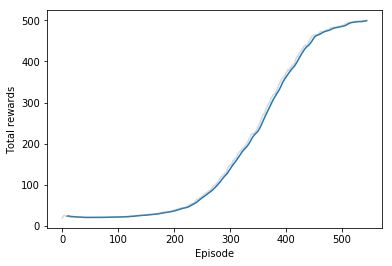

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

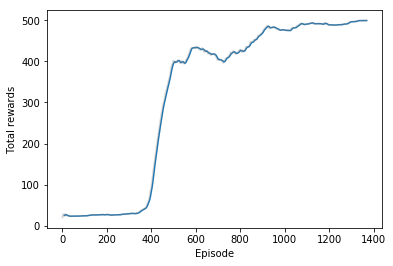

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

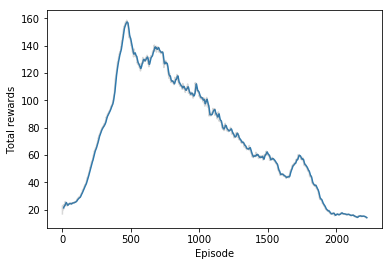

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

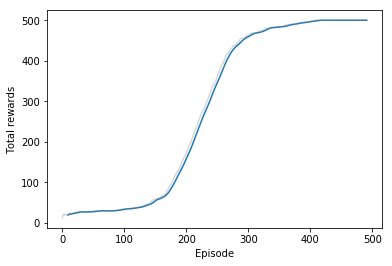

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

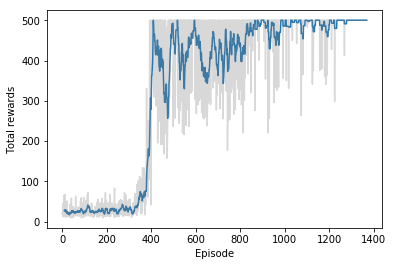

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

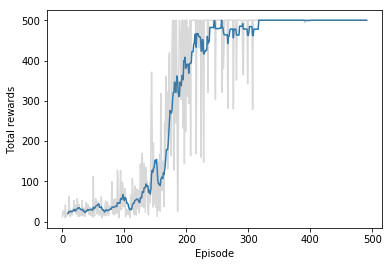

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

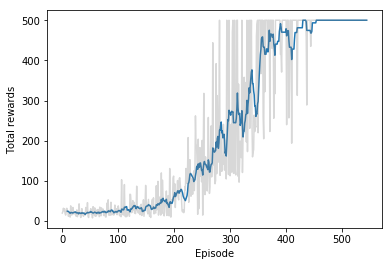

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.